In [1]:
#default_exp utils

# Utils

In [2]:
#export
from shutil import rmtree
from pathlib import Path
from warnings import warn
import sys
import os
import gc
from functools import partial
import time


from sklearn.base import BaseEstimator, clone
#import pickle library used
import pickle
import joblib

In [3]:
#export
def remove_folder_or_file(path):
    '''
    recursively remove dir and files in dir given by direcotry(path)
    '''
    path = Path(path)
    if path.exists():
        if path.is_dir():
            rmtree(path)        
        else:
            path.unlink()
    else:
        pass

    return

## Cache Handler

In [4]:
#export 
def get_pointer_names(obj):
    '''
    returns all names in scope() (globals or locals) pointing to object
    '''
    return [k for k,v in globals().items() if v is obj]

def global_delete_from_reference(varname):
    '''
    deletes varname from scope() (globals or locals) and runs gc.collect()
    '''
    globals().pop(varname)
    gc.collect()
    return

def global_set_from_reference(varname, value):
    '''
    sets value to globals()[varname] and runs gc.collect()
    '''
    globals()[varname] = value
    gc.collect()
    return

def global_delete_from_object(obj):
    '''
    removes object references from globals().    
    '''
    
    names = get_pointer_names(obj)
    
    for name in names:            
        global_delete_from_reference(name)    

def global_set_from_object(obj, value):
    '''
    sets value to references from globals().    
    '''
    names = get_pointer_names(obj)
    
    for name in names:            
        global_set_from_reference(name, value)

In [5]:
#export
class SimpleCacher():
    
    def __init__(self, obj, serializer, dirpath = './_skdag_cache', override_on_initialization = False, remove_after_gc = True, dump_kwargs = {}, load_kwargs = {}):
        
        #avoid_caching a cacher and creating nested structures
        while isinstance(obj, self.__class__):        
            obj = obj.load()
        #
        self.obj = None
        self.serializer = serializer     
        self.dirpath = Path(dirpath)        
        self.override_on_initialization = False
        self.remove_after_gc = remove_after_gc
        self.dump_kwargs = dump_kwargs
        self.load_kwargs = load_kwargs
        #extra attrs        
        self._name = f'{obj.__class__.__name__}{id(self)}'        
        self.path = self.dirpath/f'{self._name}.skdag_cache'                
        #dump obj
        self._safe_serialize(obj, override = override_on_initialization)
        return
    
    def _safe_serialize(self, obj, override = False):
        '''
        checks if file exists prior to serializing
        '''
        if not override:
            if self.path.exists():
                raise FileExistsError(f'A file already exists under {self.path.absolute()}. To override, set override = True.')

        #creates parent folders
        if not self.path.parent.exists():
            os.makedirs(dirpath)
        
        self.serializer.dump(obj, self.path, **self.dump_kwargs)
        return
    
    def __del__(self,):
        '''
        deletes serialized objects in dict when self is deleted
        '''
        if hasattr(self, 'remove_after_gc'):
            if self.remove_after_gc:
                if hasattr(self, 'path'):
                    if self.path.exists():
                        self.path.unlink()
        return
                
    def __repr__(self,):
        name = self._name
        path = self.path
        return f'{name} at <{path.absolute()}>'
    
    def dump(self, obj, override = False):
        #pickle        
        self._safe_serialize(obj, override = override)
        return self.path
    
    def load(self,):
        #unpickle        
        return self.serializer.load(self.path, **self.load_kwargs)
    
    def remove_file(self,):        
        '''
        removes file and returns object
        '''
        obj = self.load()
        remove_folder_or_file(self.path)
        return obj

        
class EstimatorCacher(BaseEstimator):

    def _unnest_cacher(self, obj):        
        
        sklearn_estim = obj
        
        while isinstance(sklearn_estim, (EstimatorCacher, SimpleCacher)):            
            if isinstance(sklearn_estim, EstimatorCacher):
                sklearn_estim = sklearn_estim.estimator.load()
            else:
                sklearn_estim = sklearn_estim.load()
                
        return sklearn_estim
    
    def __init__(self, cached_estimator, serializer = joblib, dirpath = './_skdag_cache', override_on_initialization = False, remove_after_gc = True, load_kwargs = {}, dump_kwargs = {}):

        #avoid caching a Cacher        
        self.cached_estimator = self._unnest_cacher(cached_estimator)
        self.serializer = serializer
        self.dirpath = dirpath
        self.override_on_initialization = override_on_initialization
        self.remove_after_gc = remove_after_gc
        self.load_kwargs = load_kwargs
        self.dump_kwargs = dump_kwargs
        #extra                        
        self.__initialized = True
        self.estimator_ = None
        return

    def fit(self, X, y = None, **kwargs):
        
        estim = clone(self._unnest_cacher(self.cached_estimator))
        self.estimator_ = SimpleCacher(estim, self.serializer, self.dirpath, self.override_on_initialization, self.remove_after_gc, self.load_kwargs, self.dump_kwargs)
        estim = self.estimator_.load()
        estim.fit(X, y, **kwargs)
        self.estimator_.dump(estim, override = True)        
        return self
    
    def __getattr__(self, attr):

        try:
            #checks if is instaitated
            super().__getattribute__(f'_{self.__class__.__name__}__initialized')                        
            #deserializes
            obj = super().__getattribute__('estimator_').load()
            return self._safe_access(obj, attr)            

        #case where object is not instatiated yet
        except AttributeError:
            return super().__getattribute__(attr)


    def _safe_run(self, obj, method, *args, **kwargs):
        '''
        dumps updated object after running a method or accessing a property
        '''
        result = getattr(obj, method)(*args, **kwargs)
        self.estimator_.dump(obj, override = True)
        return result


    def _safe_access(self, obj, attr):

        #handles cases where accessing attribute might change object state        
        if callable(getattr(obj.__class__, attr)):
            return partial(self._safe_run, obj, attr)

        if isinstance(getattr(obj.__class__, attr), property):
            return partial(self._safe_run, obj, attr)()
        else:
            return getattr(obj,attr)

### hide

        
class EstimatorCacher(BaseEstimator):
       
    def __init__(self, base_estimator, serializer, dirpath = './_skdag_cache', override_on_serialization = False, load_kwargs = {}, dump_kwargs = {}):
        '''
        serializer is a class containing methods
        dump and load, taking (obj,path, **load_kwargs) and (path, **dump_kwargs) as inputs as argument and * as output
        '''
                
        #set states                        
        self.dirpath = dirpath
        self.serializer = serializer                
        self.override_on_serialization = override_on_serialization
        self.dump_kwargs = dump_kwargs
        self.load_kwargs = load_kwargs
        self.base_estimator = base_estimator
        #auxiliary attrs                
        obj = clone(base_estimator)
        self.dirpath = Path(self.dirpath)
        self._obj_id = str(id(obj))
        self._name = f'{obj.__class__.__name__}{self._obj_id}'
        self.path = self.dirpath/f'{self._name}.skdag_cache'        
        #serialize object on the instatiation        
        self._safe_initialize(obj, override_on_serialization)                       
        #set _initialized attribute        
        self._initialized = True        
        return    
    
    def _safe_initialize(self, obj, override = False):
        '''
        checks if file exists prior to serializing
        '''
        if not override:
            if self.path.exists():
                raise FileExistsError(f'A file already exists under {self.path.absolute()}. To override, set override = True.')

        #creates parent folders
        if not self.path.parent.exists():
            os.makedirs(dirpath)
        
        self.serializer.dump(obj, self.path)
        return
    
    def __getitem__(self, *args, **kwargs):
        '''
        loads and gets item
        '''        
        return self.__getattr__('__getitem__')(*args, **kwargs)
    
    def __setitem__(self, *args, **kwargs):
        '''
        loads, set item and dumps new object
        '''        
        return self.__getattr__('__setitem__')(*args, **kwargs)
        
    def __getattr__(self, attr):
                        
        try:
            #checks if is instaitated
            super().__getattribute__(f'_initialized')
            #access atrbiutes in way to avoid infinite recursion
            path = super().__getattribute__('path')
            serializer = super().__getattribute__('serializer')
            #deserializes
            obj = serializer.load(path)
            return self._safe_access(obj, attr)            
        
        #case where object is not instatiated yet
        except AttributeError:
            return super().__getattribute__(attr)
        
        
    def _safe_run(self, obj, method, *args, **kwargs):
        '''
        dumps updated object after running a method or accessing a property
        '''
        result = getattr(obj, method)(*args, **kwargs)
        self.serializer.dump(obj, self.path)
        return result
        
    
    def _safe_access(self, obj, attr):
        
        #handles cases where accessing attribute might change object state        
        if callable(getattr(obj.__class__, attr)):
            return partial(self._safe_run, obj, attr)
        
        else:
            return getattr(obj,attr)
    
    def __setattr__(self, attr, value):        
        '''
        if Cacher is already instatiated (has attribute self.__initialized),
        deserializes object, sets attribute and dumps back
        '''                                    
        #setting attr prior to complete instatiation. Set atttribute to self, instead of object
        if not hasattr(self, f'_{self.__class__.__name__}__initialized'):
            super().__setattr__(attr, value)
                    
        #case after instatiation
        else:
            
            #loads object
            obj = self.serializer.load(self.path)
            
            if hasattr(obj.__class__, attr): #handles already existent attributes/properties
                #check if property
                if isinstance(getattr(obj.__class__, attr), property):
                    #check if has a setter
                    if getattr(getattr(obj.__class__, attr), 'fset') is None:
                        raise AttributeError("can't set attribute")
                    #set otherwise
                    else:
                        setattr(obj, attr, value)
                else:                    
                    obj.__setattr__(attr, value)
                #save obj with new attributes
                self.serializer.dump(obj, self.path)
                return
            
            else: #case where attribute is new
                obj.__setattr__(attr, value)
                self.serializer.dump(obj, self.path)       
        
        return       
    
    def __del__(self,):
        '''
        deletes serialized objects in dict when self is deleted
        '''
        if hasattr(self, 'path'):
            if self.path.exists():
                self.path.unlink()
        return
                
    def __repr__(self,):
        name = super().__getattribute__('_name')
        path = super().__getattribute__('path')
        return f'Cached{name} at <{path.absolute()}>'
    
    def __str__(self,):
        return self.__repr__()
    
    def load(self,):
        #unpickle        
        return self.serializer.load(self.path, **self.load_kwargs)
        
    

### hide

### Cacher example

In [6]:
#THANKS TO GDMARMEROLA AT https://gdmarmerola.github.io/big-data-ml-training/
# libs to help us track memory via sampling
import numpy as np
import tracemalloc
from time import sleep
import matplotlib.pyplot as plt

# sampling time in seconds
SAMPLING_TIME = 0.001

class MemoryMonitor:
    def __init__(self, close=True):
        
        # start tracemalloc and sets
        # measurement atribute to True
        tracemalloc.start()
        self.keep_measuring = True
        self.close = close
        
    def measure_usage(self):
        
        """
        Takes measurements of used memory on
        regular intevals determined by the 
        global SAMPLING_TIME constant
        """
        
        # list to store memory usage samples
        usage_list = []
        
        # keeps going until someone changes this parameter to false
        while self.keep_measuring:
            
            # takes a sample, stores it in the usage_list and sleeps
            current, peak = tracemalloc.get_traced_memory()
            usage_list.append(current/1e6)
            sleep(SAMPLING_TIME)
            
        # stop tracemalloc and returns list
        if self.close:
            tracemalloc.stop()
        return usage_list

# imports executor
from concurrent.futures import ThreadPoolExecutor
from functools import wraps

def plot_memory_use(history, fn_name, open_figure=True, offset=0, **kwargs):
    
    """Function to plot memory use from a history collected
        by the MemoryMonitor class
    """

    # getting times from counts and sampling time
    times = (offset + np.arange(len(history))) * SAMPLING_TIME
    
    # opening figure and plotting
    if open_figure:
        plt.figure(figsize=(10,3), dpi=120)
    plt.plot(times, history, 'k--', linewidth=1)
    plt.fill_between(times, history, alpha=0.5, **kwargs)
    
    # axes titles
    plt.ylabel('Memory usage [MB]')
    plt.xlabel('Time [seconds]')
    plt.title(f'{fn_name} memory usage over time')
    
    # legend
    plt.legend();

def track_memory_use(plot=True, close=True, return_history=False):
    
    def meta_wrapper(fn):
    
        """
        This function is meant to be used as a decorator
        that informs wrapped function memory usage
        """
        
        # decorator so we can retrieve original fn
        @wraps(fn)
        def wrapper(*args, **kwargs):

            """
            Starts wrapped function and holds a process 
            to sample memory usage while executing it
            """

            # context manager for executor
            with ThreadPoolExecutor() as executor:

                # start memory monitor
                monitor = MemoryMonitor(close=close)
                mem_thread = executor.submit(monitor.measure_usage)

                # start wrapped function and get its result
                try:
                    fn_thread = executor.submit(fn, *args, **kwargs)
                    fn_result = fn_thread.result()

                # when wrapped function ends, stop measuring
                finally:
                    monitor.keep_measuring = False
                    history = mem_thread.result()

                # inform results via prints and plot
                print(f'Current memory usage: {history[-1]:2f}')
                print(f'Peak memory usage: {max(history):2f}')
                if plot:
                    plot_memory_use(history, fn.__name__)
            if return_history:
                return fn_result, history
            else:
                return fn_result

        return wrapper
    
    return meta_wrapper

In [7]:
class HeavyEstimator(BaseEstimator):
    
    def __init__(self, shape = (10_000, 1_000)):
        self.shape = shape
        return
    
    def fit(self, X = None, y = None, **kwargs):
        self.heavy_arr_ = np.random.randn(*self.shape)
        return self
    
    def transform(self, X = None):
        return 1
    
    def predict(self, X = None):
        return 1

In [15]:
import joblib
import numpy as np
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
X = np.random.randn(10000, 100)
y = np.random.randn(10000,)

In [9]:

@track_memory_use(close=False, return_history=True)
def cycle(estimator, X, y):    
    estimator.fit(X,y)
    if hasattr(estimator, 'transform'):
        _ = estimator.transform(X)
    else:
        _ = estimator.predict(X)
    sleep(0.01)    
    return estimator


In [10]:
class Pickler:
    def __getattr__(self, attr):
        return getattr(joblib, attr)

No handles with labels found to put in legend.


Current memory usage: 27.211289
Peak memory usage: 87.807872


No handles with labels found to put in legend.


Current memory usage: 37.721747
Peak memory usage: 550.825720


No handles with labels found to put in legend.


Current memory usage: 41.059398
Peak memory usage: 53.478770


''

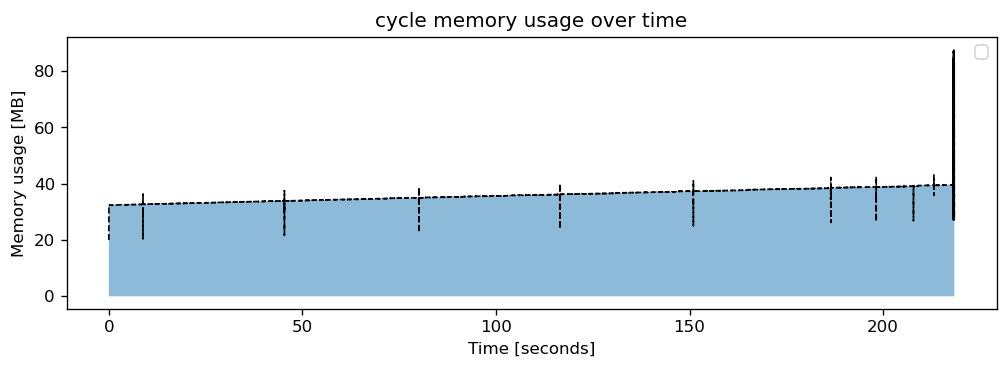

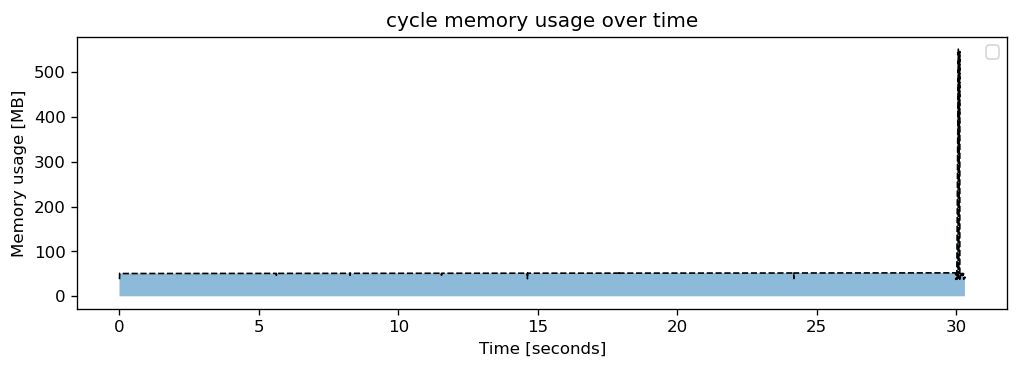

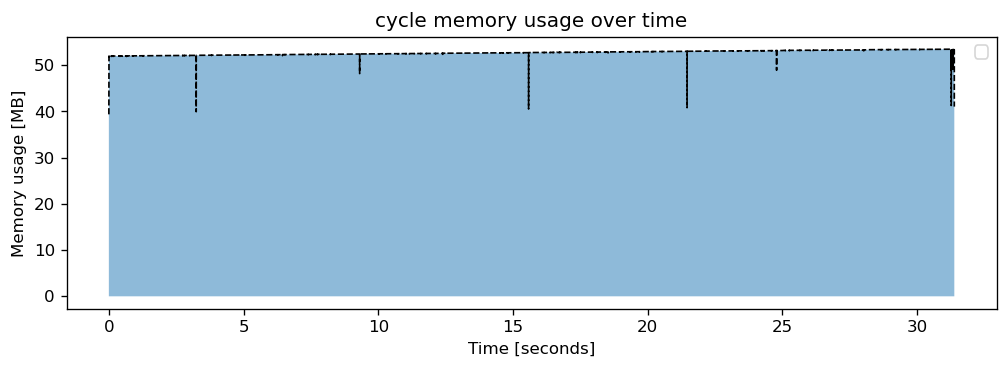

In [16]:
#base estimators to compose ensemble mthod
#regular_base = HeavyEstimator((1000,100))
regular_base = RandomForestRegressor()
cached_base = EstimatorCacher(regular_base, Pickler(), remove_after_gc = True)

#3 types of ensemble
cached_estimator = BaggingRegressor(cached_base)
regular_estimator = BaggingRegressor(regular_base)
cached_estimator2 = EstimatorCacher(regular_estimator, Pickler(), remove_after_gc = True)
#plot memory consumption
cycle(cached_estimator, X, y)
cycle(cached_estimator2, X, y)
cycle(regular_estimator, X, y)
''

In [12]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted d6tflow-sklearn.ipynb.
Converted dag.ipynb.
Converted node.ipynb.
Converted utils.ipynb.
